In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from datetime import datetime

import statsmodels.api as sm

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima.utils import ndiffs

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pickle

# Reading in data

In [40]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

italy_20 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [2]:
spain_20.tail(2)

NameError: name 'spain_20' is not defined

# Preprocessing data 

#### _Data for each country is split into different dataframes as different combinations and aggregations are needed for different functions._ 

**Resampling by month**

_`rm` denotes resampling by month._ 

In [42]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [43]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

#### Combining weekly resampled data for all years (2017-2020)

In [44]:
alltime_italy = pd.concat([italy_17_19, italy_20])
alltime_spain = pd.concat([spain_17_19, spain_20])
alltime_greece = pd.concat([greece_17_19, greece_20])

alltime_rw_italy = alltime_italy.resample("W").mean()
alltime_rw_spain = alltime_spain.resample("W").mean()
alltime_rw_greece = alltime_greece.resample("W").mean()

#### Splitting into dataframes for each year! 

In [45]:
it_rw_17 = alltime_rw_italy[0:53]
it_rw_18 = alltime_rw_italy[53:105]
it_rw_19 = alltime_rw_italy[105:158]

In [46]:
it_rw_18.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2018-12-23,25.5,0.652526,0.62446,5.345714,-7.126363,0.548571,0.098575,0.315516,0.058491,0.126928,0.464983,117.940511,209852.965714,3.985714
2018-12-30,25.5,0.637171,0.63514,4.971429,-6.814571,0.528571,0.104640,0.342631,0.066215,0.139117,0.460786,121.689883,216545.840000,3.934286


# Differencing Data for Stationarity

### Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [47]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'energy']

In [48]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'lags_used'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [49]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(alltime_rw_italy[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -3.013333
p-value           0.033668
lags_used         4.000000
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -3.470516
p-value           0.008777
lags_used         9.000000
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -6.335745e+00
p-value           2.833617e-08
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -3.355416
p-value           0.012576
lags_used         7.000000
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -6.787062e+00
p-value           2.417084e-09
lags_used         0.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic   -4.108187
p-value           0.000939
lags_used         2.000000
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -4.022911
p-value           0.001295
lags_used         2.000000
dtype: float64
Dic

### DataFrame with once-differenced data

In [50]:
lag_df_italy = alltime_rw_italy.copy()

In [51]:
for feature in audio_features: 
    lag_df_italy[f'{feature}_once_differenced'] = lag_df_italy[feature].diff(1).fillna(0)

In [52]:
lag_df_italy.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,danceability_once_differenced,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2021-02-07,25.5,0.666561,0.634389,5.402857,-6.677991,0.680000,0.109192,0.268234,0.035348,0.223654,...,0.008495,0.029374,0.18000,0.314663,0.031429,-0.001159,-0.073344,-0.001695,0.005719,-0.006398
2021-02-14,25.5,0.671104,0.647343,5.516667,-6.842603,0.656667,0.120716,0.277941,0.054173,0.220087,...,0.004543,0.012955,0.11381,-0.164612,-0.023333,0.011523,0.009707,0.018826,-0.003567,0.049983


_Dickey-Fuller on lag dataframe_

In [53]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df_italy[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -9.142255e+00
p-value           2.828632e-15
lags_used         5.000000e+00
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.518281e+00
p-value           1.118537e-13
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.002232e+00
p-value           7.272028e-10
lags_used         6.000000e+00
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -9.845662e+00
p-value           4.627101e-17
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -8.291616e+00
p-value           4.246658e-13
lags_used         5.000000e+00
dtype

_Checking that these are the same_

In [54]:
interpret_dftest(adfuller(lag_df_italy['energy_once_differenced']))

Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64

In [55]:
interpret_dftest(adfuller(lag_df_italy['energy'].diff(1).fillna(0)))

Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

In [57]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 0
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 0
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for energy stationarity w/ adf test: 0


In [58]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_rw_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 1
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for energy stationarity w/ adf test: 0


In [59]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 1
ndiffs for loudness stationarity w/ kpss test: 1
ndiffs for mode stationarity w/ kpss test: 1
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1


In [60]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_rw_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 0
ndiffs for loudness stationarity w/ kpss test: 0
ndiffs for mode stationarity w/ kpss test: 0
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1


### Finding `p`, `d`, and `q` values

_Using only the five audio features that are the most relevant or show some sort of pattern_ 

In [61]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'energy']

_Building dataframe with `ndifffs` for stationarity for each feature_

In [62]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

for feature in five_features:
    ndiff_dict['audio_feature'].append(feature)
    ndiff_dict['ndiffs for stationarity'].append(ndiffs(alltime_rw_italy[feature], test= "adf"))

ndiff_df = pd.DataFrame(ndiff_dict)
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,mode,1
2,acousticness,0
3,valence,0
4,energy,0


In [63]:
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,mode,1
2,acousticness,0
3,valence,0
4,energy,0


In [64]:
# creating markdown table for readme

print(ndiff_df.to_markdown(tablefmt="pipe"))

|    | audio_feature   |   ndiffs for stationarity |
|---:|:----------------|--------------------------:|
|  0 | danceability    |                         1 |
|  1 | mode            |                         1 |
|  2 | acousticness    |                         0 |
|  3 | valence         |                         0 |
|  4 | energy          |                         0 |


In [2]:
arima_dict = {
    'audio_feature':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'order':[],
    'ARIMA_model':[],
    'ARIMA_AIC':[]
}

def find_p_and_q(df, feature, n=6):
    
    '''
    For the specified data, finds the optimal values for the AutoRegressive term (p) and Moving Average term (q) to achieve better accuracy.
    '''
    
    train = df[feature][0:162]
    
    d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]

    # starting with large start AIC
    best_aic = 99 * (10 * 16)
    # creating variables to store best values ofd p and q 
    best_p = 0
    best_q = 0 

    # use nested for loop to iterate over values of p and q
    for p in range(n):

        for q in range(n):

            # insert try and and except statements
            try: 

                # fitting on ARIMA(p, 1, q) model 
                print(f'Attempting to fit ARIMA({p}, {d}, {q})')

                # instantiate ARIMA model
                arima = ARIMA(train, order=(p,d,q))

                # fit ARIMA model 
                model = arima.fit()

                # print out AIC for ARIMA(p, 1, q) model 
                print(f'For {feature}, the AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                # Is this current model's AIC better than the OF best_aic? 
                if model.aic < best_aic:
                    # we want aic to be lower so we are setting a high aic and hoping for something lower 

                    # if it is, we overwrite the best_aic, best_p, and best_q
                    best_aic = model.aic
                    best_p = p 
                    best_q = q

            except:
                pass 

        order = (best_p, d, best_q)
    
    arima_dict['audio_feature'].append(feature)
    arima_dict['ndiffs(d)'].append(d)
    arima_dict['best_p'].append(best_p)
    arima_dict['best_q'].append(best_q)
    arima_dict['order'].append(order)
    arima_dict['ARIMA_model'].append(f'ARIMA({best_p},{d},{best_q})')
    arima_dict['ARIMA_AIC'].append(best_aic)

    print()
    print(f'{feature.upper()} MODEL FINISHED!')
    print(f'The model for {feature} that minimizes AIC on the training data is the ARIMA({best_p},{d},{best_q}).')
    print(f'The model has an aIC of {best_aic}.')
    print()

In [66]:
arima_dict

{'audio_feature': [],
 'ndiffs(d)': [],
 'best_p': [],
 'best_q': [],
 'order': [],
 'ARIMA_model': [],
 'ARIMA_AIC': []}

In [67]:
for feature in five_features:
    find_p_and_q(rw_italy_17_19, feature)

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -705.1269635218952
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -719.9078122241333
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -719.3145992186896
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -719.0058383050268
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -718.7836792929766
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -716.8215644624875
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -716.4336321379885
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -725.3103525337362
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -726.847242195727
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(1, 1, 5)
Attempting 

In [68]:
arima_param_df = pd.DataFrame(arima_dict)
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164
4,energy,0,5,2,"(5, 0, 2)","ARIMA(5,0,2)",-690.871477


In [69]:
print(arima_param_df.to_markdown(tablefmt="pipe"))

|    | audio_feature   |   ndiffs(d) |   best_p |   best_q | order     | ARIMA_model   |   ARIMA_AIC |
|---:|:----------------|------------:|---------:|---------:|:----------|:--------------|------------:|
|  0 | danceability    |           1 |        2 |        1 | (2, 1, 1) | ARIMA(2,1,1)  |    -726.879 |
|  1 | mode            |           1 |        4 |        3 | (4, 1, 3) | ARIMA(4,1,3)  |    -430.795 |
|  2 | acousticness    |           0 |        3 |        2 | (3, 0, 2) | ARIMA(3,0,2)  |    -600.574 |
|  3 | valence         |           0 |        2 |        2 | (2, 0, 2) | ARIMA(2,0,2)  |    -627.919 |
|  4 | energy          |           0 |        5 |        2 | (5, 0, 2) | ARIMA(5,0,2)  |    -690.871 |


# ARIMA Models  

### Function to create, evaluate, and plot `ARIMA` models 

In [70]:
def arima_predict_plot(df, feature, year, title='title', figsize=(15,5), order=None, d=None, ci=True):
    
    '''
    Fits ARIMA model and makes predictions for specified data. 
    Calculates test and train RMSE scores and appends to parameter dataframe.
    Plots actual values for train and test sets and predicted values for test set. 
    '''
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    if order is None:
        # find order from arima parameters dataframe 
        order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
   
    # instantiate ARIMA model
    model = ARIMA(train, order=order)

    # fit ARIMA model
    arima = model.fit()
    
    # get predictions for train and test sets 
    preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
    preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'arima_train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'arima_test_rmse'] = test_rmse
    
      # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

_Function soley for creating and fitting the ARIMA model._

In [71]:
def arima_fit_eval(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None):
    
    '''
    Fits ARIMA model and makes predictions for specified data. 
    Calculates test and train RMSE scores and appends to parameter dataframe.
    '''
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    if order is None:
        # find order from arima parameters dataframe 
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
   
    # instantiate ARIMA model
    model = ARIMA(train, order=order)

    # fit ARIMA model
    arima = model.fit()
    
    # get predictions for train and test sets 
    preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
    preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')
    
    # add RMSEs to arima parameters dataframe 
    param_df.loc[param_df['audio_feature'] == feature, 'arima_train_rmse'] = train_rmse    
    param_df.loc[param_df['audio_feature'] == feature, 'arima_test_rmse'] = test_rmse
    
    return arima 

_Function soley for plotting to be used when needed._

In [72]:
def arima_plot(train, test, preds_test, title='title', figsize=(15,5), ci=True):
    
    '''
    For given data, Plots actual values for train and test sets and predicted values for test set. 
    '''
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    # plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

### ARIMA Models - 2017

_Using `arima_predict_plot` function to run ARIMA model for each feature and show plot of actual vs. test._

_This will also add columns for `arima_train_rmse` and `arima_test_rmse`._

In [73]:
it_rw_17.head(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,0.466054,115.511720,257468.600000,3.860000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,0.390494,118.564109,279987.502857,3.908571


In [74]:
it_rw_17.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-12-24,25.5,0.612843,0.674063,5.302857,-6.309091,0.657143,0.123394,0.253601,0.013014,0.179737,0.443628,108.77560,221529.465714,3.900000
2017-12-31,25.5,0.610449,0.656787,5.637143,-6.322729,0.688571,0.102279,0.209149,0.022378,0.171537,0.415203,116.60734,218028.402857,3.908571


In [1]:
arima_predict_plot(it_rw_17, feature, 2017, title=f'Mean Valence Score, Italy 2017 (ARIMA)')

NameError: name 'arima_predict_plot' is not defined

In [36]:
for feature in five_features: 
    arima_predict_plot(it_rw_17, feature, 2017, title=f'Mean {feature.capitalize()} Score, Italy 2017 (ARIMA)')

NameError: name 'arima_predict_plot' is not defined

#### _Updated `arima_param_df`_

In [262]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325
4,energy,0,5,2,"(5, 0, 2)","ARIMA(5,0,2)",-690.871477,0.027185,0.021975


# SARIMAX models 

#### _As baseline, Fitting SARIMAX with `seasonal_order = (2, 0, 2, 52)` and no exogenous variables before incorporating/engineering those components._

RMSE = 0.05


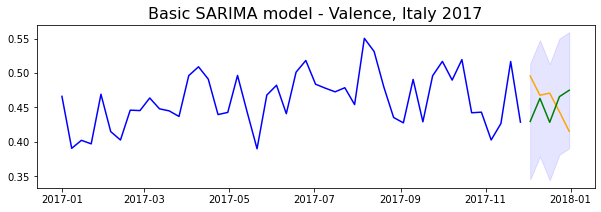

In [266]:
P, D, Q, S = 2, 0 ,2, 52
train_val = it_rw_17['valence'][0:48]
test_val = it_rw_17['valence'][48:]

sarima_val = SARIMAX(endog = train_val, order = (2, 0, 2), seasonal_order = (P, D, Q, S)).fit()
# sarima_pred = sarima.predict(start=start, end = end)

preds_train_sarima_val = sarima_val.predict(start=train_val.index[0], end=train_val.index[-1])
preds_test_sarima_val = sarima_val.predict(start=test_val.index[0], end=test_val.index[-1])

print(f'RMSE = {round(mean_squared_error(test_val, preds_test_sarima_val)**.5, 2)}')

arima_plot(train_val, test_val, preds_test_sarima_val, title="Basic SARIMA model - Valence, Italy 2017", figsize=(10,3))

#### Plotting ARIMA plot from above again, for comparison: 

d = 0
order = (2, 0, 2)
Valence train RMSE (2017) - ARIMA((2, 0, 2)): 0.035572561609325974
Valence test RMSE (2017) - ARIMA((2, 0, 2)): 0.03332529150268263


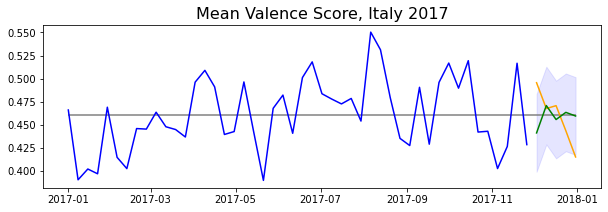

In [267]:
arima_predict_plot(it_rw_17, 'valence', 2017, title=f'Mean Valence Score, Italy 2017', figsize=(10,3))

### SARIMAX Seasonal Parameters

#### _Grid search to find best `P`, `D`, `Q`, and `s` values_

In [268]:
def find_sarima_parameters(df, feature, n_rows=47):    
    
    '''
    For specified data, finds the best seasonal order hyperparameters (P,D,Q,s) to achieve better accuracy for predictions. 
    '''
    
    import time
    t0 = time.time()
    final_mae = 1000000000000
    final_S = 0
    final_D = 0
    final_P = 0
    final_Q = 0
    
    # find order from arima parameters dataframe 
    order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]

    train_values = df[feature][0:n_rows]
    test_values = df[feature][n_rows:]

    for S in range(48,53):
        for D in range(2):
            for P in range(4):
                for Q in range(4):
                    print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                    try:
                        sarima = SARIMAX(endog = train_values,
                                         order = order,
                                         seasonal_order = (P, D, Q, S)).fit()

                        sarima_pred = sarima.predict(start=test_values.index[0], end=test_values.index[-1], typ='levels')

                        if mean_absolute_error(test_values, sarima_pred) < final_mae:
                            final_mae = mean_absolute_error(test_values, sarima_pred)
                            final_S = S
                            final_D = D
                            final_P = P
                            final_Q = Q

                        print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE and {mean_squared_error(test_values, sarima_pred)**0.5} RMSE.')

                    except:
                        print('problem!')
                        raise

    print()
    print(f'The final model for {feature} is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')
    print()

In [140]:
five_features

['danceability', 'mode', 'acousticness', 'valence', 'tempo']

In [270]:
for feature in five_features:
    find_sarima_parameters(alltime_rw_italy, feature)

Checking (0, 0, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 0, 48) model with 0.05753386489055584 MAE and 0.06516625912711418 RMSE.
Checking (0, 0, 1, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 1, 48) model with 0.057244647772963383 MAE and 0.06489035081204642 RMSE.
Checking (0, 0, 2, 48) at 1 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 2, 48) model with 0.057356183192151494 MAE and 0.06500243980415928 RMSE.
Checking (0, 0, 3, 48) at 5 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 3, 48) model with 0.05738887528626105 MAE and 0.06503604179073746 RMSE.
Checking (1, 0, 0, 48) at 13 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 0, 48) model with 0.05742365142378605 MAE and 0.06506007287612735 RMSE.
Checking (1, 0, 1, 48) at 15 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 1, 48) model with 0.05711023161189308 MAE and 0.06477479310037171 RMSE.
Checking (1, 0, 2, 48) at 16 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 2, 48) model with 0.06613950024815429 

Results from SARIMA seasonal order grid search using 2017-2020 data:

+ The final model for danceability is SARIMAX(2, 0, 2)x(2, 0, 3, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(0, 0, 0, 48).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(0, 1, 0, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(1, 0, 3, 50).
+ The final model for energy is SARIMAX(2, 0, 2)x(0, 0, 2, 51).

In [273]:
arima_param_df.loc[arima_param_df['audio_feature'] == 'danceability', 'seasonal_order_all_data'] = '2, 0, 3, 48'
arima_param_df.loc[arima_param_df['audio_feature'] == 'mode', 'seasonal_order_all_data'] = '0, 0, 0, 48'
arima_param_df.loc[arima_param_df['audio_feature'] == 'acousticness', 'seasonal_order_all_data'] = '0, 1, 0, 48'
arima_param_df.loc[arima_param_df['audio_feature'] == 'valence', 'seasonal_order_all_data'] = '1, 0, 3, 50'
arima_param_df.loc[arima_param_df['audio_feature'] == 'energy', 'seasonal_order_all_data'] = '0, 0, 2, 51'

In [271]:
find_sarima_parameters(it_rw_17, 'energy')

Checking (0, 0, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 0, 48) model with 0.019350375250552016 MAE and 0.023903161702126183 RMSE.
Checking (0, 0, 1, 48) at 1 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 1, 48) model with 0.015942847988861548 MAE and 0.021409032990458658 RMSE.
Checking (0, 0, 2, 48) at 3 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 2, 48) model with 0.0199759640816126 MAE and 0.025213900453149203 RMSE.
Checking (0, 0, 3, 48) at 13 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 3, 48) model with 0.022435339886466604 MAE and 0.02785512553769112 RMSE.
Checking (1, 0, 0, 48) at 41 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 0, 48) model with 0.019230375424677076 MAE and 0.023718749122552937 RMSE.
Checking (1, 0, 1, 48) at 45 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 1, 48) model with 0.02816639900453784 MAE and 0.034865495288712904 RMSE.
Checking (1, 0, 2, 48) at 49 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 2, 48) model with 0.02504455423

In [141]:
# Note: This was ran when tempo was included instead of energy; now I am using energy, and the `alltime_rw_italy` run uses energy 
for feature in five_features: 
    find_sarima_parameters(it_rw_17, feature)

Checking (0, 0, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 0, 48) model with 0.02535439624913416 MAE and 0.03235024699693846 RMSE.
Checking (0, 0, 1, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 1, 48) model with 0.02530012454173834 MAE and 0.03235445125658867 RMSE.
Checking (0, 0, 2, 48) at 1 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 2, 48) model with 0.02522953394499224 MAE and 0.03231597528729935 RMSE.
Checking (0, 0, 3, 48) at 4 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 3, 48) model with 0.025200232385478194 MAE and 0.032300443440283794 RMSE.
Checking (1, 0, 0, 48) at 12 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 0, 48) model with 0.025351736406543812 MAE and 0.03236137962655508 RMSE.
Checking (1, 0, 1, 48) at 14 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 1, 48) model with 0.025072120974000744 MAE and 0.032271091282727773 RMSE.
Checking (1, 0, 2, 48) at 15 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 2, 48) model with 0.028274897847032

Results SARIMA seasonal order grid search using only 2017 data:
+ The final model for danceability is SARIMAX(2, 0, 2)x(3, 0, 0, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(1, 0, 1, 52).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(1, 0, 2, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(0, 0, 1, 49).
+ The final model for energy is SARIMAX(2, 0, 2)x(0, 0, 3, 51).

#### _Adding Seasonal Orders to `arima_param_df`_

citation: converting string to tuple https://www.geeksforgeeks.org/python-convert-string-to-tuple/

In [292]:
arima_param_df.loc[arima_param_df['audio_feature'] == 'danceability', 'seasonal_order'] = '3, 0, 0, 48'
arima_param_df.loc[arima_param_df['audio_feature'] == 'mode', 'seasonal_order'] = '1, 0, 1, 52'
arima_param_df.loc[arima_param_df['audio_feature'] == 'acousticness', 'seasonal_order'] = '1, 0, 2, 48'
arima_param_df.loc[arima_param_df['audio_feature'] == 'valence', 'seasonal_order'] = '0, 0, 1, 49'
arima_param_df.loc[arima_param_df['audio_feature'] == 'energy', 'seasonal_order'] = '0, 0, 3, 51'

#### _Updated `arima_param_df`_

In [293]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data,sarima_train_rmse,sarima_test_rmse,exog_train_rmse,exog_test_rmse
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448,"3, 0, 0, 48","2, 0, 3, 48",0.026049,0.021293,0.020645,0.022201
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383,"1, 0, 1, 52","0, 0, 0, 48",0.066625,0.109086,0.066179,0.107475
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290,"1, 0, 2, 48","0, 1, 0, 48",0.059960,0.019439,0.095177,0.055358
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325,"0, 0, 1, 49","1, 0, 3, 50",0.076294,0.025510,0.023856,0.042838
4,energy,0,5,2,"(5, 0, 2)","ARIMA(5,0,2)",-690.871477,0.027185,0.021975,"0, 0, 3, 51","0, 0, 2, 51",0.089395,0.020495,0.026434,0.025111


#### _Function for SARIMA w/ seasonal components, no exogenous variables:_

In [294]:
def sarima_predict_plot_seasonal(df, feature, year, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):
    
    '''
    Fits SARIMA model and makes predictions for specified data. 
    Calculates test and train RMSE scores and appends to parameter dataframe.
    Plots actual values for train and test sets and predicted values for test set. 
    '''
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    # instantiate and fit SARIMAX model 
    sarima = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order).fit()

    # get predictions for train and test sets 
    preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels')
    preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - SARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - SARIMA({order}): {test_rmse}')    
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'sarima_train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'sarima_test_rmse'] = test_rmse
    
    # calculate residuals
    # residuals = test - preds_test
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

d = 1
order = (2, 1, 1)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2017) - SARIMA((2, 1, 1)): 0.02604860270283264
Danceability test RMSE (2017) - SARIMA((2, 1, 1)): 0.02129312854030801


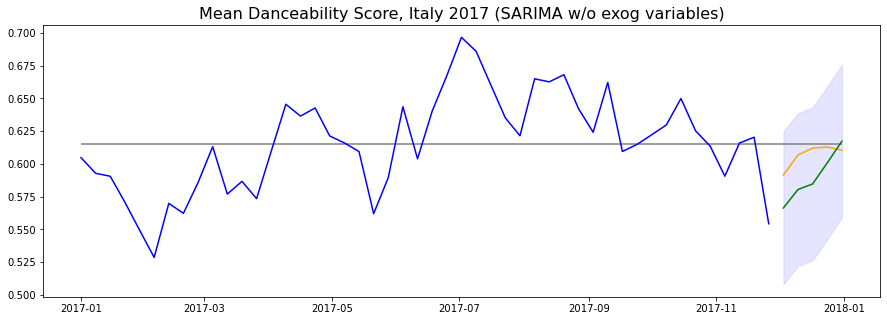

d = 1
order = (4, 1, 3)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2017) - SARIMA((4, 1, 3)): 0.06662545896440102
Mode test RMSE (2017) - SARIMA((4, 1, 3)): 0.10908603704861933


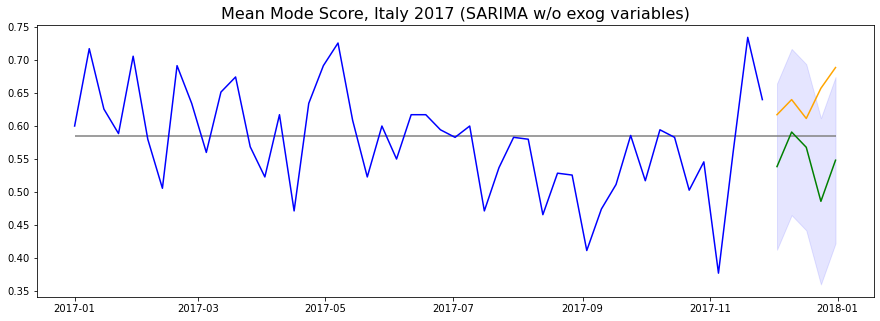

d = 0
order = (3, 0, 2)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2017) - SARIMA((3, 0, 2)): 0.0599604383435671
Acousticness test RMSE (2017) - SARIMA((3, 0, 2)): 0.01943910236962413


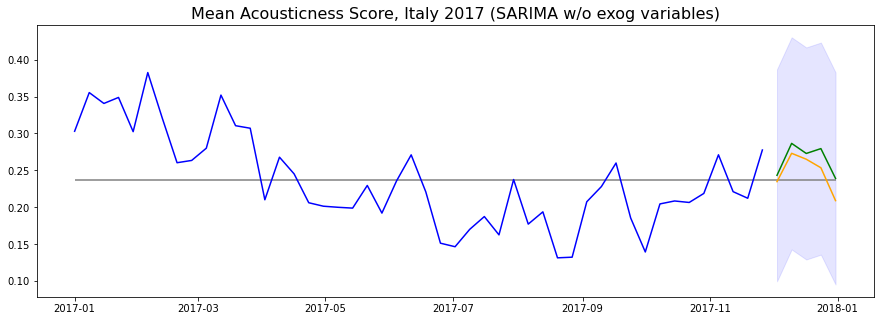

d = 0
order = (2, 0, 2)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2017) - SARIMA((2, 0, 2)): 0.0762942717827684
Valence test RMSE (2017) - SARIMA((2, 0, 2)): 0.025510262698733292


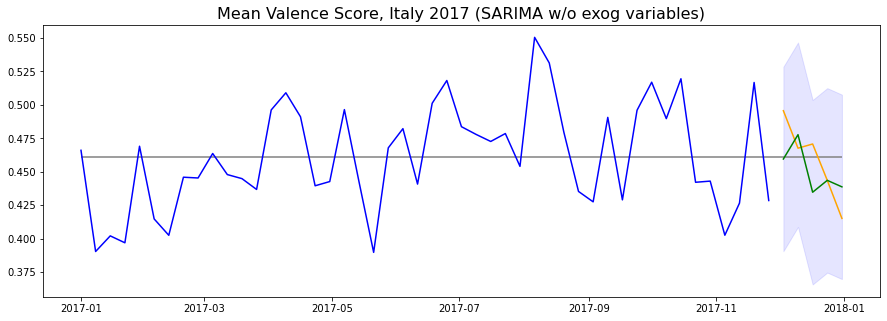

d = 0
order = (5, 0, 2)
seasonal order = (0, 0, 3, 51)
Energy train RMSE (2017) - SARIMA((5, 0, 2)): 0.08939490355155377
Energy test RMSE (2017) - SARIMA((5, 0, 2)): 0.020494909397274767


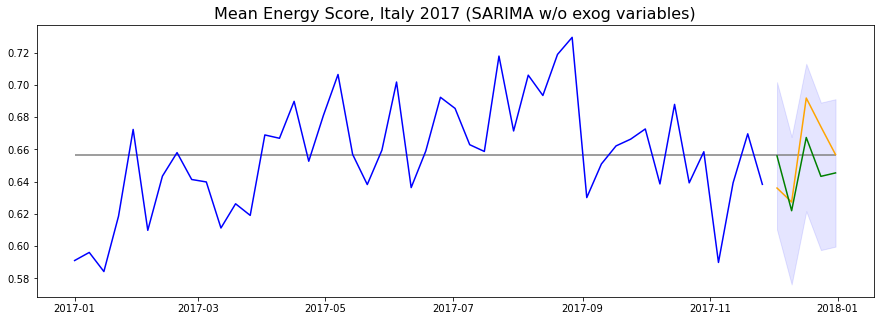

In [295]:
for feature in five_features:
    sarima_predict_plot_seasonal(it_rw_17, feature, 2017, title=f'Mean {feature.capitalize()} Score, Italy 2017 (SARIMA w/o exog variables)')

#### _Updated `arima_param_df`_

In [296]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data,sarima_train_rmse,sarima_test_rmse,exog_train_rmse,exog_test_rmse
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448,"3, 0, 0, 48","2, 0, 3, 48",0.026049,0.021293,0.020645,0.022201
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383,"1, 0, 1, 52","0, 0, 0, 48",0.066625,0.109086,0.066179,0.107475
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290,"1, 0, 2, 48","0, 1, 0, 48",0.059960,0.019439,0.095177,0.055358
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325,"0, 0, 1, 49","1, 0, 3, 50",0.076294,0.025510,0.023856,0.042838
4,energy,0,5,2,"(5, 0, 2)","ARIMA(5,0,2)",-690.871477,0.027185,0.021975,"0, 0, 3, 51","0, 0, 2, 51",0.089395,0.020495,0.026434,0.025111


#### _Incorporating Exogenous Variables in SARIMAX models_

In [297]:
def sarima_predict_plot_exog(df, feature, year, exog_var, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):
    
    '''
    Fits SARIMAX model and makes predictions for specified data. 
    Calculates test and train RMSE scores and appends to parameter dataframe.
    Plots actual values for train and test sets and predicted values for test set. 
    '''

    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    # reshape exogenous features to pass to the model 
    exog = df.loc[:, exog_var]   
   
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # instantiate and fit SARIMAX model 
    sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=seasonal_order).fit()

    # get predictions for train and test sets 
    preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
    preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {test_rmse}')    
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'exog_train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'exog_test_rmse'] = test_rmse

    # calculate residuals
    # residuals = test - preds_test
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

_Identifying exogenous variables for each of the five main features, which for each of them is the other four audio features_

In [298]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'energy']

exog_danceability = ['mode', 'acousticness', 'valence', 'energy']
exog_mode = ['danceability', 'acousticness', 'valence', 'energy']
exog_acousticness = ['danceability', 'mode', 'valence', 'energy']
exog_valence = ['danceability', 'mode', 'acousticness', 'energy']
exog_energy = ['danceability', 'mode', 'acousticness', 'valence']

d = 1
order = (2, 1, 1)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2017) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.020644649265561962
Danceability test RMSE (2017) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.02220128106078873


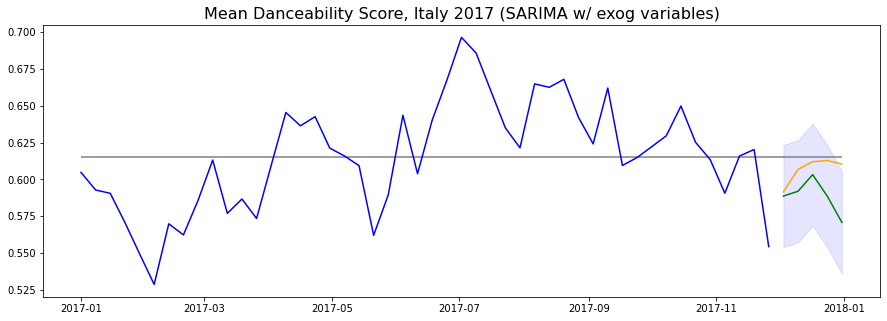

In [284]:
sarima_predict_plot_exog(it_rw_17, 'danceability', 2017, exog_var=exog_danceability, title=f'Mean Danceability Score, Italy 2017 (SARIMA w/ exog variables)')

In [285]:
# for feature in five_features:
#     sarima_predict_plot_exog(it_rw_17, feature, 2017, exog_var=f'exog_{feature}', title=f'Mean {feature} Score, Italy 2017 (SARIMA w/ exog variables)')

d = 1
order = (4, 1, 3)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2017) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.06617878641985477
Mode test RMSE (2017) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.10747505378827199


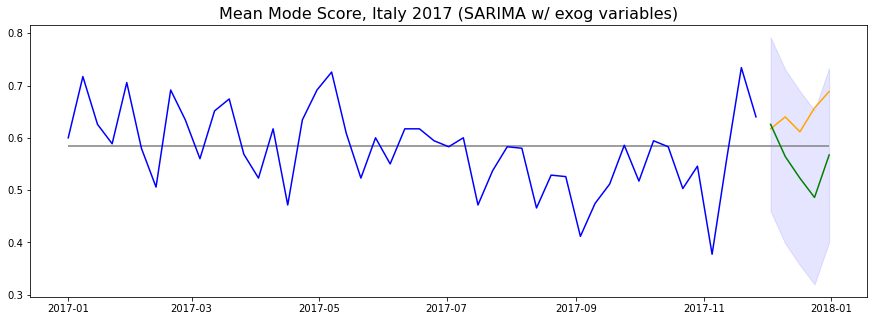

In [286]:
sarima_predict_plot_exog(it_rw_17, 'mode', 2017, exog_var=exog_mode, title=f'Mean Mode Score, Italy 2017 (SARIMA w/ exog variables)')

d = 0
order = (3, 0, 2)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2017) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.09517665733432738
Acousticness test RMSE (2017) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.05535836617917216


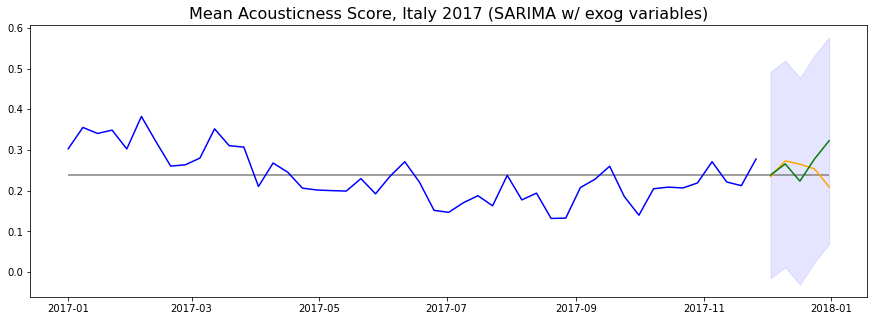

In [287]:
sarima_predict_plot_exog(it_rw_17, 'acousticness', 2017, exog_var=exog_acousticness, title=f'Mean Acousticness Score, Italy 2017 (SARIMA w/ exog variables)')

d = 0
order = (2, 0, 2)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2017) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.023856391231660317
Valence test RMSE (2017) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.04283822181305334


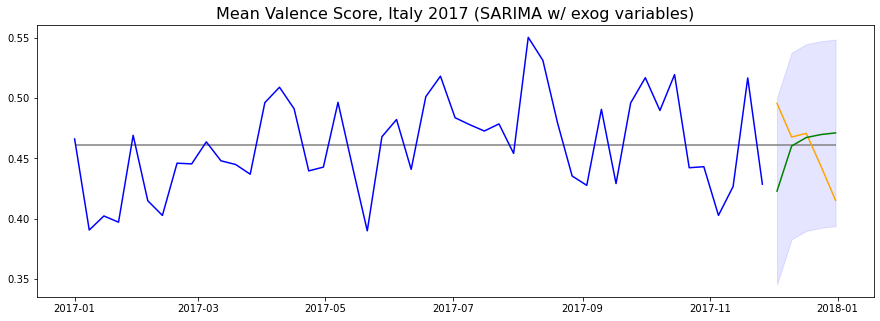

In [288]:
sarima_predict_plot_exog(it_rw_17, 'valence', 2017, exog_var=exog_valence, title=f'Mean Valence Score, Italy 2017 (SARIMA w/ exog variables)')

d = 0
order = (5, 0, 2)
seasonal order = (0, 0, 3, 51)
Energy train RMSE (2017) - SARIMAX((0, 0, 3, 51)) w/ exogenous variables: 0.02643373731220653
Energy test RMSE (2017) - SARIMAX((0, 0, 3, 51)) w/ exogenous variables: 0.025111017631778396


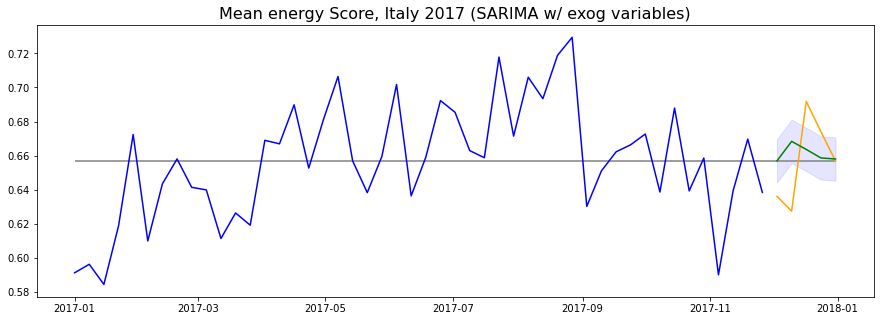

In [289]:
sarima_predict_plot_exog(it_rw_17, 'energy', 2017, exog_var=exog_energy, title=f'Mean energy Score, Italy 2017 (SARIMA w/ exog variables)')

#### _Updated `arima_param_df`_

In [290]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data,sarima_train_rmse,sarima_test_rmse,exog_train_rmse,exog_test_rmse
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448,"3, 0, 0, 48","2, 0, 3, 48",0.026049,0.021293,0.020645,0.022201
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383,"1, 0, 1, 52","0, 0, 0, 48",0.066625,0.109086,0.066179,0.107475
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290,"1, 0, 2, 48","0, 1, 0, 48",0.059960,0.019439,0.095177,0.055358
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325,"0, 0, 1, 49","1, 0, 3, 50",0.076294,0.025510,0.023856,0.042838
4,energy,0,5,2,"(5, 0, 2)","ARIMA(5,0,2)",-690.871477,0.027185,0.021975,"0, 0, 3, 51","0, 0, 2, 51",0.089395,0.020495,0.026434,0.025111


#### _Pickling 2017 `arima_param_df` to compare with other years in another notebook_

In [301]:
arima_param_df.to_pickle('./metrics/2017_sarima_param_df.pkl')

_Note about scaling: For each of the audio features I used, the songs were scored on a 0 to 1 scale. Therefore the weekly averages for each feature were also on the 0 to 1 scale, which meant that it was unnecessary to perform scaling on this data._